In [1]:
%%time
import s3fs
import xarray as xr

url_1 = "s3://hrrrzarr/sfc/20210927/20210927_06z_fcst.zarr/surface/TMP"
url_2 = f"{url_1}/surface"

fs = s3fs.S3FileSystem(anon=True)
s3_lookups = [s3fs.S3Map(url, s3=fs) for url in [url_1, url_2]]

forecast_tmp = xr.open_mfdataset(s3_lookups,
                                 engine="zarr")
forecast_tmp

CPU times: user 1.43 s, sys: 293 ms, total: 1.72 s
Wall time: 3.21 s


<xarray.Dataset>
Dimensions:                  (time: 48, projection_x_coordinate: 1799,
                              projection_y_coordinate: 1059)
Coordinates:
  * time                     (time) datetime64[ns] 2021-09-27T07:00:00 ... 20...
  * projection_x_coordinate  (projection_x_coordinate) float64 -2.698e+06 ......
  * projection_y_coordinate  (projection_y_coordinate) float64 -1.587e+06 ......
Data variables:
    TMP                      (time, projection_y_coordinate, projection_x_coordinate) float16 dask.array<chunksize=(48, 150, 150), meta=np.ndarray>
    forecast_period          (time) timedelta64[ns] dask.array<chunksize=(48,), meta=np.ndarray>
    forecast_reference_time  datetime64[ns] ...

In [2]:
forecast_tmp.TMP

<xarray.DataArray 'TMP' (time: 48, projection_y_coordinate: 1059,
                         projection_x_coordinate: 1799)>
dask.array<open_dataset-0bfd417c84a447fc99212dc5370f69c3TMP, shape=(48, 1059, 1799), dtype=float16, chunksize=(48, 150, 150), chunktype=numpy.ndarray>
Coordinates:
  * time                     (time) datetime64[ns] 2021-09-27T07:00:00 ... 20...
  * projection_x_coordinate  (projection_x_coordinate) float64 -2.698e+06 ......
  * projection_y_coordinate  (projection_y_coordinate) float64 -1.587e+06 ......
Attributes:
    GRIB_PARAM:   [2, 0, 0, 0]
    coordinates:  forecast_reference_time forecast_period
    long_name:    surface/TMP
    units:        K

In [3]:
%%time
forecast_tmp.TMP.max().values

CPU times: user 1.65 s, sys: 454 ms, total: 2.1 s
Wall time: 27.2 s


array(320., dtype=float16)

/opt/anaconda3/envs/hrrr-zarr/lib/python3.10/site-packages/pyproj/__init__.py:89: UserWarning: pyproj unable to set database path.
  _pyproj_global_context_initialize()


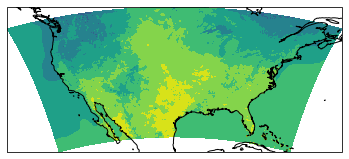

In [4]:
# Troubleshoot: Since Jupyter is running from a different conda kernel than the notebook is using, I have to
# run something like this to get the below code to work

import pyproj
pyproj.datadir.set_data_dir("/opt/anaconda3/envs/hrrr-zarr/share/proj")

import metpy
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from datetime import datetime

forecast_tmp = forecast_tmp.rename(projection_x_coordinate="x", projection_y_coordinate="y")
forecast_tmp = forecast_tmp.metpy.assign_crs(grid_mapping_name="lambert_conformal_conic", 
                         longitude_of_central_meridian=-97.5,
                             latitude_of_projection_origin=38.5,
                             standard_parallel=38.5)
forecast_tmp = forecast_tmp.metpy.assign_latitude_longitude()

ax = plt.axes(projection=ccrs.PlateCarree())
ax.contourf(forecast_tmp.longitude, forecast_tmp.latitude,
            forecast_tmp.TMP.sel(time=datetime(2021, 9, 28, 18)))
ax.coastlines()

plt.show()

AttributeError: 'Dataset' object has no attribute 'projection_x_coordinate'

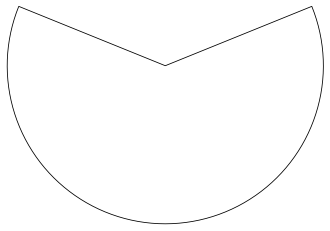

In [5]:
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
from datetime import datetime

projection = ccrs.LambertConformal(central_longitude=-97.5,
                             central_latitude=38.5,
                             standard_parallels=[38.5])

ax = plt.axes(projection=projection)
ax.contourf(forecast_tmp.projection_x_coordinate, forecast_tmp.projection_y_coordinate,
            forecast_tmp.TMP.sel(time=datetime(2021, 9, 28, 18)))
ax.coastlines()

plt.show()

In [ ]:
airport_lat, airport_lon = 40.47, -111.58

x, y = projection.transform_point(airport_lon, airport_lat, ccrs.PlateCarree())
airport_forecast = forecast_tmp.sel(projection_x_coordinate=x, projection_y_coordinate=y,
                                    method="nearest")
plt.plot(airport_forecast.time, airport_forecast.TMP)

In [ ]:
airport_lat, airport_lon = 40.47, -111.58

x, y = projection.transform_point(airport_lon, airport_lat, ccrs.PlateCarree())
airport_forecast = forecast_tmp.sel(x=x, y=y,
                                    method="nearest")
airport_forecast.TMP.plot()

In [ ]:
%%time
import s3fs
import xarray as xr
from datetime import date
import cartopy.crs as ccrs

# Some boilerplate to make URLs
reference_time = datetime(2021, 10, 5, 12)
var_name = "REFC"
var_level = "entire_atmosphere"

fs = s3fs.S3FileSystem(anon=True)
root_url = reference_time.strftime("s3://hrrrzarr/sfc/%Y%m%d/%Y%m%d_%Hz_fcst.zarr")

s3_lookups = [s3fs.S3Map(url, s3=fs) for url in [f"{root_url}/{var_level}/{var_name}", 
                                                 f"{root_url}/{var_level}/{var_name}/{var_level}"]]

# Look up the data
forecast_refl = xr.open_mfdataset(s3_lookups, engine="zarr")

# Get SLC airport coordinates
projection = ccrs.LambertConformal(central_longitude=-97.5,
                             central_latitude=38.5,
                             standard_parallels=[38.5])
airport_lat, airport_lon = 40.47, -111.58
x, y = projection.transform_point(airport_lon, airport_lat, ccrs.PlateCarree())


# Get forecast for tomorrow 12z at the gridpoint nearest to the airport
airport_forecast = forecast_refl.sel(time=[datetime(2021, 10, 6, 12), datetime(2021, 10, 6, 18)],
                                     projection_x_coordinate=x, projection_y_coordinate=y, 
                                     method="nearest")
print(airport_forecast.REFC.values)

In [ ]:
%%time
import zarr
refc_data = zarr.open("s3://hrrrzarr/sfc/20211005/20211005_12z_fcst.zarr/entire_atmosphere/REFC/entire_atmosphere/REFC")
fcst_24 = refc_data[23]
print(refc_data.shape, fcst_24.shape, fcst_24.max())

In [ ]:
f"{root_url}/{var_level}/{var_name}/{var_level}/{var_name}"

In [ ]:
plt.scatter(range(48), refc_data[:, 634, 503])

In [ ]:
grid = xr.open_zarr("s3://hrrrzarr/grid/HRRR_chunk_index.zarr/")
grid

In [ ]:
point = grid.sel(x=x, y=y, method="nearest")
print(point.index_x.values, point.index_y.values, point.latitude.values, point.longitude.values)

In [ ]:
forecast_refl

In [ ]:
print(point.x.values, point.y.values)
print(airport_forecast.projection_x_coordinate.values, 
      airport_forecast.projection_y_coordinate.values)

In [ ]:
import metpy

apl = forecast_refl.rename(projection_x_coordinate="x", projection_y_coordinate="y")
apl = apl.metpy.assign_crs(grid_mapping_name="lambert_conformal_conic", 
                         longitude_of_central_meridian=-97.5,
                             latitude_of_projection_origin=38.5,
                             standard_parallel=38.5)
apl = apl.metpy.assign_latitude_longitude()
apl

In [ ]:
afl = apl.sel(time=[datetime(2021, 10, 6, 12), datetime(2021, 10, 6, 18)],
                                     x=x, y=y, 
                                     method="nearest")
print(afl.REFC.values, afl.latitude.values, afl.longitude.values)
print(point.index_x.values, point.index_y.values, point.latitude.values, point.longitude.values)